# Effect of increasing phenotypic data on components of IGS-SSBR evaluation

## Theory

IGS-SSBR evaluation has a marker and polygenic components. This simulation will examine the accurcacy of these components as the amount of phenotypic data increases. 

### Model

$$
\begin{align}
\mathbf{y} &= \mathbf{1}\mu + \mathbf{Z}\mathbf{M}\boldsymbol{\alpha} + \mathbf{Zu} + \mathbf{e} \\
           &= \mathbf{1}\mu + \mathbf{Z}\mathbf{g} + \mathbf{Z}\mathbf{u} + \mathbf{e} \\
           &= \mathbf{1}\mu + \mathbf{Z}(\mathbf{g} + \mathbf{u}) + \mathbf{e} \\
           &= \mathbf{1}\mu + \mathbf{Z}\mathbf{a} + \mathbf{e},
\end{align}
$$

where

$$
\begin{align}
\text{Var}(\mathbf{a}) &= \mathbf{G}\sigma^2_g + \mathbf{A}\sigma^2_u\\
                       &= (\mathbf{G}\frac{\sigma^2_g}{\sigma^2_a} + \mathbf{A}\frac{\sigma^2_u}{\sigma^2_a})\sigma^2_a\\
                       &= \mathbf{H}\sigma^2_a,
\end{align}
$$

$\mathbf{G} = \mathbf{M}\mathbf{M}'/(pH)$, $p$ is the number of markers, $H$ is the average heterozygosity, $\mathbf{A}$ is the pedigree-based additive relationship matrix, and $\sigma^2_a = \sigma^2_g + \sigma^2_u$.


### Mixed model equations:

$$
\begin{bmatrix}
\mathbf{1}'\mathbf{1} & \mathbf{1}'\mathbf{Z}\\
\mathbf{1}            & \mathbf{Z'}\mathbf{Z} + \mathbf{H}^{-1}\lambda 
\end{bmatrix}
\begin{bmatrix}
\hat{\mu} \\
\hat{\mathbf{a}}
\end{bmatrix}
= 
\begin{bmatrix}
\mathbf{1}'\mathbf{y}\\
Z'\mathbf{y}\\
\end{bmatrix},
$$

where $\lambda = \sigma^2_e/\sigma^2_a$. BLUP of $\mathbf{g}$ and $\mathbf{u}$ can be obtained as:

$$
\hat{\mathbf{g}} = \frac{\sigma^2_g}{\sigma^2_a}\mathbf{G}\mathbf{H}^{-1}\hat{\mathbf{a}}
$$
and 
$$
\hat{\mathbf{u}} = \frac{\sigma^2_u}{\sigma^2_a}\mathbf{A}\mathbf{H}^{-1}\hat{\mathbf{a}}
$$

In [3]:
using XSim
using JWAS
using DelimitedFiles
using CSV
using Statistics
using LinearAlgebra
using Plots
using Distributions
using Random
using Printf
pyplot()

Plots.PyPlotBackend()

## Functions

### Function halfsibFamily: get pedigree for halfsib family

In [4]:
function halfsibFamily(n)
    ind = 1:(1+2n)
    sire = [0;repeat([0],n);repeat([1],n)]
    dam  = [0;repeat([0],n);2:n+1]
    ped = [ind sire dam]
end

halfsibFamily (generic function with 1 method)

### Function extendPed: extend pedigree

In [5]:
function extendPed(ped,ped1)
    n = ped[end,1]
    ind = ped1[:,1] .+ n
    sire = [s==0 ? 0 : s+n for s in ped1[:,2]]
    dam = [d==0 ? 0 : d+n for d in ped1[:,3]]
    ped = [ped;
           [ind sire dam]
        ]
end

extendPed (generic function with 1 method)

### Function simData: simulate marker and QTL genotypes

In [6]:
function simData(nn,qtl,mrk,h2,founders)

    ped = halfsibFamily(nn[1])
    for i in nn[2:end]
        ped1 = halfsibFamily(i)
        ped = extendPed(ped,ped1)
    end

    writedlm("ped.csv",ped)

    pedigree   = get_pedigree("ped.csv",header=false,separator='\t');

    temp = Matrix(JWAS.PedModule.AInverse(pedigree));
    indx = [pedigree.idMap[string(i)].seqID for i in 1:size(ped,1)]
    Ai   = temp[indx,indx]
    A    = inv(Ai);

    animals = samplePed(ped,founders)
    QM = getOurGenotypes(animals)

    M = QM[:,mrk]
    Q = QM[:,qtl]
    n,p = size(M)
    return Q,M,A,ped
end

simData (generic function with 1 method)

### Function getMME: get MME

In [88]:
function getMME(nn,Q,M,A,ped,h2,wtMrk)
    
    n,p = size(M)
    
    sires = unique(ped[:,2])
    sires = sires[2:end]
    dams = unique(ped[:,3])
    dams = dams[2:end]
    offsp  = setdiff(ped[:,1],[sires;dams])
    cand = [1; sires]                       # candidates
    offsp = setdiff(offsp,cand)
    nOffsp = size(offsp,1)

    Z   = Matrix{Float64}(I,n,n)[offsp,:]
    ZPZ = Diagonal(Z'Z);

    G   = M*M'
    Het = mean(diag(G))
    G   = G/Het + I*0.001
    
    genVar = mean([dot(Q[i,:],Q[i,:]) for i=1:size(Q,1)])
    resVar = genVar*(1-h2)/h2

    var_g = genVar*wtMrk
    var_u = genVar*(1.0-wtMrk)

    H  = (G*var_g/genVar + A*var_u/genVar)
    genVarVec = diag(H)*genVar
    Hi = inv(H)
    J  = ones(nOffsp)

    λ  = resVar/genVar

    mme = [
    J'J J'Z
    Z'J ZPZ+Hi*λ   
    ]
    Ch = cholesky(Symmetric(mme));
    Pg = var_g/genVar*G*Hi
    Pu = var_u/genVar*A*Hi
    mmei = inv(Ch)
    d = diag(mmei)
    d = d[2:end]
    pev = d[cand]*resVar
    coruHatu = (genVarVec[cand] - pev) ./genVarVec[cand]
    coruHatu = map(x->x>0.0 ? sqrt(x) : 0.0,coruHatu)
    println("coruHatu")
    for i=1:size(nn,1)
        @printf("%4d %5.2f\n",nn[i],coruHatu[i])
    end
    return Pg,Pu,Ch,J,Z,offsp,cand,genVar,resVar,coruHatu
end

getMME (generic function with 1 method)

### Function simBLUP: simulate phenotypes and get BLUPs 

In [51]:
function simBLUP(Q,Pg,Pu,Ch,J,Z,n,offsp,cand,resVar)
    α = randn(size(Q,2))
    a = Q*α
    y = a + randn(n)*sqrt(resVar)
    y = y[offsp]
    rhs = [J'y; Z'y]
    sol = Ch\rhs
    aHat = sol[2:end]    # .+ sol[1]
    gHat = Pg*aHat
    uHat = Pu*aHat
    #a    = a    .- mean(a)
    #aHat = aHat .- mean(aHat)
    #gHat = gHat .- mean(gHat)
    #uHat = uHat .- mean(uHat)
    [aHat gHat uHat a][cand,:]
end

simBLUP (generic function with 1 method)

### Function accuracyBLUP: compupte correlations and regressions between predictor and predictants

In [9]:
function accuracyBLUP(res,j)
    pred = vcat([i[j,:]' for i in res]...)
    cor_u_uHat = cor(pred)[1:3,4]
    covMat = cov(pred)
    d = diag(covMat)
    reg_u_uHat = covMat[1:3,4] ./ d[1:3]
    [cor_u_uHat; reg_u_uHat]
end

accuracyBLUP (generic function with 1 method)

In [10]:
function varBLUP(res,j)
    pred = vcat([i[j,:]' for i in res]...)
    cor_u_uHat = cor(pred)[1:3,4]
    vars = var(pred,dims=1)
end

varBLUP (generic function with 1 method)

In [11]:
function covBLUP(res,j)
    pred = vcat([i[j,:]' for i in res]...)
    covs = cov(pred,dims=1)
    [covs[1:3,4]'./covs[4,4] covs[4,4]]
end

covBLUP (generic function with 1 method)

## Use of XSim to Simulate Genotypes

In [12]:
chrLength = 30.0
numChr    = 1
numLoci   = 6000
mutRate   = 0.0

0.0

### Setup of map positions for markers and QTL

In [13]:
mapPos = fill(0,60_000)
mrkPos = 10:20:60_000

qtlPos = mrkPos .+ 1

mapPos[mrkPos] .= 1
mapPos[qtlPos] .= 2

r = 30.00/60_000
map_pos = []
for (i,x) in enumerate(mapPos)
    if x>0
        push!(map_pos,i*r)
    end
end

mrkIndx = []
count = 0
for x in mapPos
    if x>0
        count += 1
        if x==1 
            push!(mrkIndx,count)
        end
    end
end

qtlIndx = []
count = 0
for x in mapPos
    if x>0
        count += 1
        if x==2 
            push!(qtlIndx,count)
        end
    end
end

### Simulation of Founders

In [14]:
geneFreq = fill(0.5,numLoci)
build_genome(numChr,chrLength,numLoci,float.(geneFreq),float.(map_pos),mutRate);

G0 = Any[]


In [15]:
popSizeFounder = 100
sires = sampleFounders(popSizeFounder)
dams  = sampleFounders(popSizeFounder);

Sampling 100 animals into base population.
Sampling 100 animals into base population.


### Simulation of random mating to generate LD

In [16]:
popSize = 200
nGen    = 100
sires,dams,gen = sampleRan(popSize, nGen,sires,dams;gen=1);

Generation     2: sampling   100 males and   100 females
Generation     3: sampling   100 males and   100 females
Generation     4: sampling   100 males and   100 females
Generation     5: sampling   100 males and   100 females
Generation     6: sampling   100 males and   100 females
Generation     7: sampling   100 males and   100 females
Generation     8: sampling   100 males and   100 females
Generation     9: sampling   100 males and   100 females
Generation    10: sampling   100 males and   100 females
Generation    11: sampling   100 males and   100 females
Generation    12: sampling   100 males and   100 females
Generation    13: sampling   100 males and   100 females
Generation    14: sampling   100 males and   100 females
Generation    15: sampling   100 males and   100 females
Generation    16: sampling   100 males and   100 females
Generation    17: sampling   100 males and   100 females
Generation    18: sampling   100 males and   100 females
Generation    19: sampling   10

In [17]:
popSize = 1000
nGen    = 1
sires,dams,gen = sampleRan(popSize, nGen,sires,dams;gen=gen);

Generation   102: sampling   500 males and   500 females


In [18]:
parents=concatCohorts(sires,dams);

### Simulation of genotypes

In [19]:
Random.seed!(31415926123);
nn = [0,1,2,10,25,50,100,200,400]
h2 = 0.25
wtMrk = 1.0
Q,M,A,ped = simData(nn,qtlIndx,mrkIndx,h2,parents);

The delimiter in ped.csv is '	'.


coding pedigree... 100%|████████████████████████████████| Time: 0:00:00
calculating inbreeding... 100%|█████████████████████████| Time: 0:00:00


Pedigree informatin:
#individuals: 1585
#sires:       8
#dams:        788
#founders:    797


In [20]:
mean(Q)

1.0077846477392218

In [21]:
Qc = Q .- mean(Q,dims=1)
Mc = M .- mean(M,dims=1);

## Simulation of BLUP Evaluations

### Weights for marker and pedigree components: 1.0, 0.0

In [92]:
wtMrk = 1.0
Pg,Pu,Ch,J,Z,offsp,cand,genVar,resVar,coruHatu =  getMME(nn,Qc,Mc,A,ped,h2,wtMrk);

coruHatu
   0  0.41
   1  0.45
   2  0.51
  10  0.68
  25  0.80
  50  0.86
 100  0.90
 200  0.92
 400  0.92


In [93]:
nReps = 10_000
n   = size(Q,1)
res = [simBLUP(Qc,Pg,Pu,Ch,J,Z,n,offsp,cand,resVar) for i=1:nReps]
resAccuracy = [accuracyBLUP(res,j) for j=1:size(cand,1)]
corrReg = hcat(resAccuracy...)'
[nn corrReg]

9×7 Array{Float64,2}:
   0.0  0.320613  0.320613  NaN  0.780689  0.780689  NaN
   1.0  0.351422  0.351422  NaN  0.796203  0.796203  NaN
   2.0  0.456769  0.456769  NaN  0.929951  0.929951  NaN
  10.0  0.664682  0.664682  NaN  1.00675   1.00675   NaN
  25.0  0.781675  0.781675  NaN  0.984394  0.984394  NaN
  50.0  0.857616  0.857616  NaN  1.00101   1.00101   NaN
 100.0  0.894532  0.894532  NaN  0.997656  0.997656  NaN
 200.0  0.914775  0.914775  NaN  1.00142   1.00142   NaN
 400.0  0.913499  0.913499  NaN  0.99095   0.99095   NaN

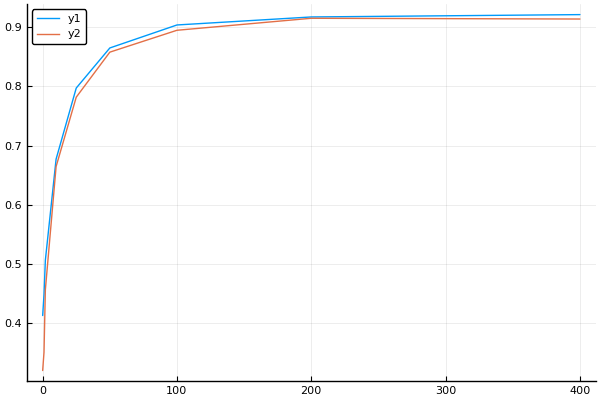

In [94]:
plot(nn,[coruHatu corrReg[:,1]])

In [95]:
covMat = [nn vcat([covBLUP(res,i) for i=1:9]...)]

9×5 Array{Float64,2}:
   0.0  0.131669  0.131669  0.0  1119.15 
   1.0  0.155108  0.155108  0.0  1149.02 
   2.0  0.224353  0.224353  0.0  1223.98 
  10.0  0.43884   0.43884   0.0  1183.26 
  25.0  0.620702  0.620702  0.0  1149.47 
  50.0  0.734761  0.734761  0.0  1159.73 
 100.0  0.802067  0.802067  0.0  1162.17 
 200.0  0.835627  0.835627  0.0  1101.23 
 400.0  0.842101  0.842101  0.0   895.359

In [96]:
res100 = [coruHatu, corrReg, covMat];

### Weights for marker and pedigree components: 0.95, 0.05

In [97]:
wtMrk = 0.95
Pg,Pu,Ch,J,Z,offsp,cand,genVar,resVar,coruHatu =  getMME(nn,Qc,Mc,A,ped,h2,wtMrk);

coruHatu
   0  0.39
   1  0.44
   2  0.49
  10  0.67
  25  0.79
  50  0.86
 100  0.90
 200  0.91
 400  0.92


In [98]:
nReps = 10_000
n   = size(Q,1)
res = [simBLUP(Qc,Pg,Pu,Ch,J,Z,n,offsp,cand,resVar) for i=1:nReps]
resAccuracy = [accuracyBLUP(res,j) for j=1:size(cand,1)]
corrReg = hcat(resAccuracy...)'
[nn corrReg]

9×7 Array{Float64,2}:
   0.0  0.315623  0.315623  -0.0221897  0.781113  0.781113  -3.23675e14
   1.0  0.359904  0.359025   0.206266   0.827613  0.837482  16.3714    
   2.0  0.448452  0.446808   0.324093   0.938927  0.956399  19.2653    
  10.0  0.661756  0.660177   0.576622   1.01      1.0497    18.0835    
  25.0  0.790701  0.790065   0.714394   0.999611  1.04488   18.1887    
  50.0  0.852845  0.852346   0.787675   1.00051   1.04629   19.0191    
 100.0  0.895584  0.895131   0.803806   0.995472  1.04132   17.8218    
 200.0  0.916191  0.915738   0.844772   1.00743   1.05841   17.4413    
 400.0  0.910723  0.910016   0.838198   0.976957  1.02944   15.7771    

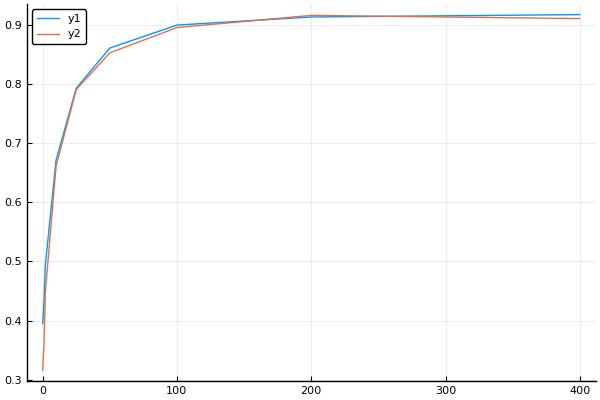

In [99]:
plot(nn,[coruHatu corrReg[:,1]])

In [100]:
covMat = [nn vcat([covBLUP(res,i) for i=1:9]...)]

9×5 Array{Float64,2}:
   0.0  0.127534  0.127534  -1.52123e-18  1081.79 
   1.0  0.156512  0.153913   0.00259877   1123.84 
   2.0  0.214191  0.208739   0.00545211   1204.08 
  10.0  0.433585  0.415198   0.0183865    1179.81 
  25.0  0.625452  0.597393   0.0280591    1173.35 
  50.0  0.726973  0.694351   0.0326215    1159.23 
 100.0  0.805718  0.769465   0.0362536    1127.14 
 200.0  0.833215  0.792298   0.0409167    1104.33 
 400.0  0.84898   0.804448   0.0445315     867.404

In [101]:
res95 = [coruHatu, corrReg, covMat];

### Weights for marker and pedigree components: 0.5, 0.5

In [102]:
wtMrk = 0.5
Pg,Pu,Ch,J,Z,offsp,cand,genVar,resVar,coruHatu =  getMME(nn,Qc,Mc,A,ped,h2,wtMrk);

coruHatu
   0  0.22
   1  0.32
   2  0.40
  10  0.63
  25  0.76
  50  0.83
 100  0.87
 200  0.89
 400  0.89


In [103]:
nReps = 10_000
n   = size(Q,1)
res = [simBLUP(Qc,Pg,Pu,Ch,J,Z,n,offsp,cand,resVar) for i=1:nReps]
resAccuracy = [accuracyBLUP(res,j) for j=1:size(cand,1)]
corrReg = hcat(resAccuracy...)'
[nn corrReg]

9×7 Array{Float64,2}:
   0.0  0.297245  0.297245  -0.000676473  1.27919   1.27919  -5.77096e12
   1.0  0.364331  0.368779   0.225209     1.11311   1.48888   1.81743   
   2.0  0.464943  0.458464   0.358773     1.15979   1.65423   2.16962   
  10.0  0.661383  0.650213   0.60147      1.0543    1.81007   1.9951    
  25.0  0.782923  0.769447   0.741424     1.02639   1.82461   2.01557   
  50.0  0.85402   0.841976   0.825615     1.01686   1.8241    2.07428   
 100.0  0.897616  0.883532   0.855103     1.02432   1.80037   2.07144   
 200.0  0.909968  0.895754   0.87686      0.991399  1.83523   1.93178   
 400.0  0.911446  0.89622    0.880134     0.95393   1.80643   1.81749   

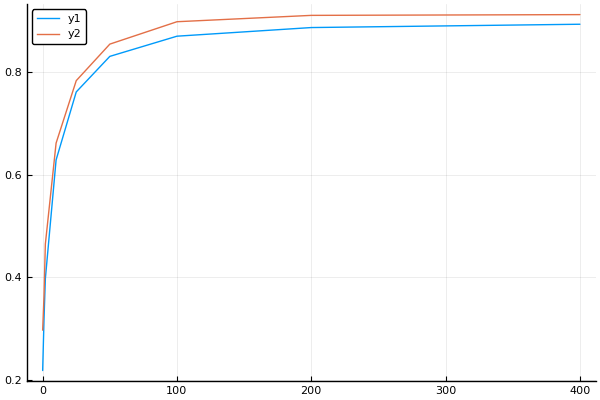

In [104]:
plot(nn,[coruHatu corrReg[:,1]])

In [105]:
covMat = [nn vcat([covBLUP(res,i) for i=1:9]...)]

9×5 Array{Float64,2}:
   0.0  0.0690705  0.0690705  -7.92964e-20  1131.39 
   1.0  0.11925    0.0913424   0.0279072    1137.68 
   2.0  0.186389   0.127061    0.0593275    1210.16 
  10.0  0.414897   0.23357     0.181328     1160.05 
  25.0  0.597211   0.324479    0.272732     1172.13 
  50.0  0.717259   0.388643    0.328616     1159.24 
 100.0  0.786583   0.433592    0.352991     1157.55 
 200.0  0.835225   0.437207    0.398018     1074.01 
 400.0  0.870853   0.444641    0.426212      907.048

In [106]:
res50 = [coruHatu, corrReg, covMat];

### Weights for marker and pedigree components: 0.0, 1.0

In [107]:
wtMrk = 0.0
Pg,Pu,Ch,J,Z,offsp,cand,genVar,resVar,coruHatu =  getMME(nn,Qc,Mc,A,ped,h2,wtMrk);

coruHatu
   0  0.00
   1  0.25
   2  0.34
  10  0.61
  25  0.74
  50  0.80
 100  0.84
 200  0.86
 400  0.88


In [108]:
nReps = 10_000
n   = size(Q,1)
res = [simBLUP(Qc,Pg,Pu,Ch,J,Z,n,offsp,cand,resVar) for i=1:nReps]
resAccuracy = [accuracyBLUP(res,j) for j=1:size(cand,1)]
corrReg = hcat(resAccuracy...)'
[nn corrReg]

9×7 Array{Float64,2}:
   0.0  NaN         NaN  NaN         NaN         NaN  NaN       
   1.0    0.249701  NaN    0.249701    0.991986  NaN    0.991986
   2.0    0.370423  NaN    0.370423    1.10663   NaN    1.10663 
  10.0    0.623434  NaN    0.623434    1.04952   NaN    1.04952 
  25.0    0.769185  NaN    0.769185    1.05995   NaN    1.05995 
  50.0    0.845353  NaN    0.845353    1.0413    NaN    1.0413  
 100.0    0.887155  NaN    0.887155    1.02686   NaN    1.02686 
 200.0    0.903331  NaN    0.903331    0.983922  NaN    0.983922
 400.0    0.907534  NaN    0.907534    0.902145  NaN    0.902145

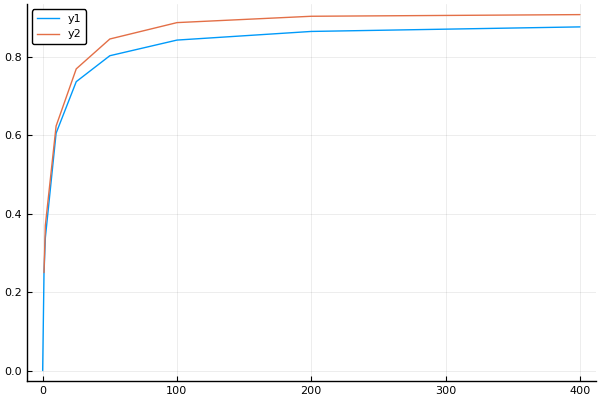

In [109]:
plot(nn,[coruHatu corrReg[:,1]])

In [110]:
covMat = [nn vcat([covBLUP(res,i) for i=1:9]...)]

9×5 Array{Float64,2}:
   0.0  0.0        0.0  0.0        1117.97 
   1.0  0.0628542  0.0  0.0628542  1119.27 
   2.0  0.123992   0.0  0.123992   1188.35 
  10.0  0.370332   0.0  0.370332   1161.37 
  25.0  0.558183   0.0  0.558183   1180.55 
  50.0  0.686281   0.0  0.686281   1162.75 
 100.0  0.766457   0.0  0.766457   1152.08 
 200.0  0.829341   0.0  0.829341   1104.95 
 400.0  0.912956   0.0  0.912956    898.515